FeaturesDict({
    'image': Image(shape=(500, 500, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
})
827


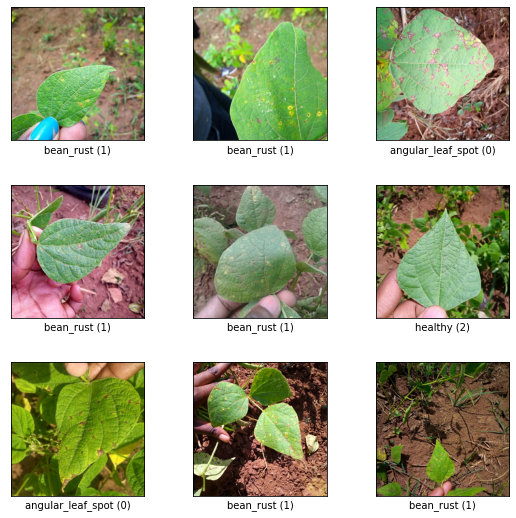

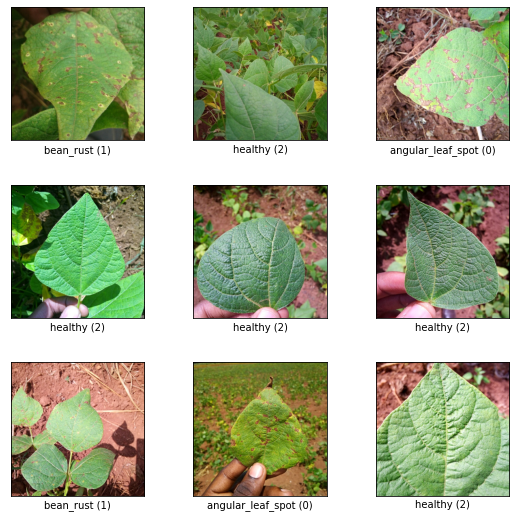

In [22]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

#데이터 획득
(ds_train, ds_val),ds_info = tfds.load(
    'beans',
    split=['train[:80%]','train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요.
print(ds_info.features)

# 데이터의 개수도 확인해 봅시다.
train_size = tf.data.experimental.cardinality(ds_train).numpy()
print(train_size)

input_shape=(128,128,3)

# Q. 이미지의 표현이 0과 1 사이로 들어오도록 직접 정규화 코드를 작성해봅시다.
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image,input_shape[:2])
    image = tf.cast(image, tf.float32) / 255.
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=4
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(16)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

#예시 이미지
fig = tfds.show_examples(ds_train, ds_info)
fig = tfds.show_examples(ds_val, ds_info)

# 데이터 정규화
BATCH_SIZE = 128
EPOCH = 15

train_ds = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
val_ds = apply_normalize_on_dataset(ds_val, batch_size=BATCH_SIZE)



In [23]:
# #블록 생성
def build_resnet_block(inputs,channel,is_50,is_plain,block_count):
  x = inputs
  for i in range(block_count):
    s = x # skip connection 지정
    if is_50 == False:
      if x.shape[-1] != channel:
        x = keras.layers.Conv2D(filters=channel,kernel_size=(3,3),strides=2,padding='same')(x)
        s = keras.layers.Conv2D(filters=channel,kernel_size=(1,1),strides=2,padding='same')(s) #스킵 커넥션 shape 같이 변경
        s = keras.layers.BatchNormalization()(s)
      else:
        x = keras.layers.Conv2D(filters=channel,kernel_size=(3,3),padding='same')(x)
      x = keras.layers.BatchNormalization()(x)
      x = keras.layers.Activation('relu')(x)

      x = keras.layers.Conv2D(filters=channel,kernel_size=(3,3),padding='same')(x)
      x = keras.layers.BatchNormalization()(x)
      if is_plain == False:
        x = keras.layers.Add()([x, s]) # 합치기
      x = keras.layers.Activation('relu')(x)
    else:
      if x.shape[-1] != channel and x.shape[-1] != channel*4: #블록 시작할때 사이즈 줄이기
        x = keras.layers.Conv2D(filters=channel,kernel_size=(1,1),strides=2,padding='same')(x)
        s = keras.layers.Conv2D(filters=channel*4,kernel_size=(1,1),strides=2,padding='same')(s) #스킵 커넥션 shape 같이 변경
        s = keras.layers.BatchNormalization()(s)
      else:
        x = keras.layers.Conv2D(filters=channel,kernel_size=(1,1),padding='same')(x)
      x = keras.layers.BatchNormalization()(x)
      x = keras.layers.Activation('relu')(x)

      x = keras.layers.Conv2D(filters=channel,kernel_size=(3,3),padding='same')(x)
      x = keras.layers.BatchNormalization()(x)
      x = keras.layers.Activation('relu')(x)

      x = keras.layers.Conv2D(filters=channel*4,kernel_size=(1,1),padding='same')(x)
      x = keras.layers.BatchNormalization()(x)

      if s.shape[-1] != x.shape[-1]: # 스킵커넥션 형태 안맞을때 형태 맞추기
        s = keras.layers.Conv2D(filters=channel*4,kernel_size=(1,1),padding='same')(s) #스킵 커넥션 shape 같이 변경
        s = keras.layers.BatchNormalization()(s)

      if is_plain == False:
        x = keras.layers.Add()([x, s]) # 합치기
      x = keras.layers.Activation('relu')(x)


  return x

# resnet_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
# resnet_block_output = build_resnet_block(inputs=resnet_input_layer)    # VGG 블록 생성

# 블록 1개짜리 model 생성
# model = keras.Model(inputs=resnet_input_layer, outputs=resnet_block_output)
# model.summary()

# reset 모델 생성
def build_resnet(input_shape=(32,32,3),is_50=False,block_counts=[3,4,6,3],
                 channels=[64,128,256,512],name='resnet'):
  inputs = keras.layers.Input(shape=input_shape)

  x = keras.layers.Conv2D(filters=channels[0],kernel_size=(7,7),strides=2,padding='same')(inputs)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Activation('relu')(x)
  x = keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2)(x)

  for (block_count,channel) in zip(block_counts,channels):
    if is_50 == False:
      x = build_resnet_block(x, channel,False,False,block_count)
    else:
      x = build_resnet_block(x, channel,True,False,block_count)

  x = keras.layers.Activation('relu')(x)
  x = keras.layers.AveragePooling2D(pool_size=(1,1))(x)
  x = keras.layers.Flatten()(x)
  outputs = keras.layers.Dense(3,activation='softmax')(x)

  model = keras.Model(inputs=inputs, outputs=outputs,name=name)

  return model

resnet_34 = build_resnet(input_shape=input_shape, is_50=False,name='resnet_34')
resnet_34.summary()

resnet_50 = build_resnet(input_shape=input_shape, is_50=True,name='resnet_50')
resnet_50.summary()

def build_plainnet(input_shape=(32,32,3),is_50=False,block_counts=[3,4,6,3],
                   channels=[64,128,256,512],name='plainnet'):
  inputs = keras.layers.Input(shape=input_shape)

  x = keras.layers.Conv2D(filters=channels[0],kernel_size=(7,7),strides=2,padding='same')(inputs)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Activation('relu')(x)
  x = keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2)(x)

  for (block_count,channel) in zip(block_counts,channels):
    if is_50 == False:
      x = build_resnet_block(x, channel,False,True,block_count)
    else:
      x = build_resnet_block(x, channel,True,True,block_count)

  x = keras.layers.Activation('relu')(x)
  x = keras.layers.AveragePooling2D(pool_size=(1,1))(x)
  x = keras.layers.Flatten()(x)
  outputs = keras.layers.Dense(3,activation='softmax')(x)

  model = keras.Model(inputs=inputs, outputs=outputs)

  return model

plainnet_34 = build_plainnet(input_shape=input_shape, is_50=False,name='plainnet_34')
plainnet_34.summary()

plainnet_50 = build_plainnet(input_shape=input_shape, is_50=True,name='plainnet_50')
plainnet_50.summary()


Model: "resnet_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1068 (Conv2D)            (None, 64, 64, 64)   9472        input_25[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1068 (Batch (None, 64, 64, 64)   256         conv2d_1068[0][0]                
__________________________________________________________________________________________________
activation_1008 (Activation)    (None, 64, 64, 64)   0           batch_normalization_1068[0][0]   
__________________________________________________________________________________________

Epoch 1/15
51/51 [==============================] - 21s 251ms/step - loss: 0.4883 - accuracy: 0.8211 - val_loss: 1.1108 - val_accuracy: 0.3623
Epoch 2/15
51/51 [==============================] - 11s 215ms/step - loss: 0.0054 - accuracy: 0.9998 - val_loss: 1.2599 - val_accuracy: 0.3478
Epoch 3/15
51/51 [==============================] - 11s 222ms/step - loss: 4.0681e-04 - accuracy: 1.0000 - val_loss: 1.4484 - val_accuracy: 0.3604
Epoch 4/15
51/51 [==============================] - 11s 223ms/step - loss: 4.1165e-04 - accuracy: 1.0000 - val_loss: 1.6529 - val_accuracy: 0.4028
Epoch 5/15
51/51 [==============================] - 11s 223ms/step - loss: 2.2668e-04 - accuracy: 1.0000 - val_loss: 1.7268 - val_accuracy: 0.3961
Epoch 6/15
51/51 [==============================] - 11s 224ms/step - loss: 2.0046e-04 - accuracy: 1.0000 - val_loss: 1.8719 - val_accuracy: 0.3797
Epoch 7/15
51/51 [==============================] - 11s 220ms/step - loss: 1.7154e-04 - accuracy: 1.0000 - val_loss: 1.9571 - 

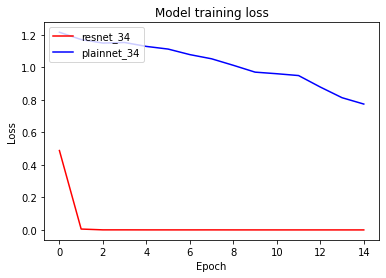

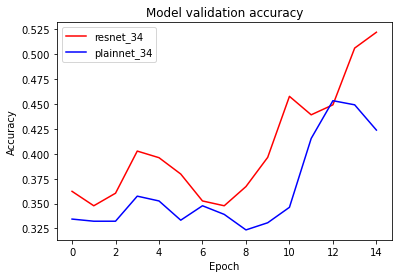

In [24]:

#resnet_34,plainnet_34
BATCH_SIZE = 16
EPOCH = 15

train_size = tf.data.experimental.cardinality(ds_train).numpy()
val_size = tf.data.experimental.cardinality(ds_val).numpy()
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_r_34 = resnet_34.fit(
    train_ds,
    steps_per_epoch=int(train_size/BATCH_SIZE),
    validation_steps=int(val_size/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=val_ds,
    verbose=1,
    use_multiprocessing=True,
)

plainnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_p_34 = plainnet_34.fit(
    train_ds,
    steps_per_epoch=int(train_size/BATCH_SIZE),
    validation_steps=int(val_size/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=val_ds,
    verbose=1,
    use_multiprocessing=True,
)


plt.plot(history_r_34.history['loss'], 'r')
plt.plot(history_p_34.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plainnet_34'], loc='upper left')
plt.show()

plt.plot(history_r_34.history['val_accuracy'], 'r')
plt.plot(history_p_34.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plainnet_34'], loc='upper left')
plt.show()


In [ ]:
plt.plot(history_r_34.history['val_loss'], 'r')
plt.plot(history_p_34.history['val_loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plainnet_34'], loc='upper left')
plt.show()

plt.plot(history_r_34.history['val_accuracy'], 'r')
plt.plot(history_p_34.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plainnet_34'], loc='upper left')
plt.show()


Epoch 1/15
51/51 [==============================] - 38s 476ms/step - loss: 1.5176 - accuracy: 0.4156 - val_loss: 1.1193 - val_accuracy: 0.3482
Epoch 2/15
51/51 [==============================] - 22s 425ms/step - loss: 1.2488 - accuracy: 0.4913 - val_loss: 1.1717 - val_accuracy: 0.3491
Epoch 3/15
51/51 [==============================] - 21s 416ms/step - loss: 1.1189 - accuracy: 0.5359 - val_loss: 1.2664 - val_accuracy: 0.3482
Epoch 4/15
51/51 [==============================] - 21s 412ms/step - loss: 1.0104 - accuracy: 0.5760 - val_loss: 1.1318 - val_accuracy: 0.3460
Epoch 5/15
51/51 [==============================] - 22s 423ms/step - loss: 0.8823 - accuracy: 0.6232 - val_loss: 1.3279 - val_accuracy: 0.3545
Epoch 6/15
51/51 [==============================] - 21s 410ms/step - loss: 0.7689 - accuracy: 0.6847 - val_loss: 1.6033 - val_accuracy: 0.3438
Epoch 7/15
51/51 [==============================] - 22s 418ms/step - loss: 0.6477 - accuracy: 0.7290 - val_loss: 1.8890 - val_accuracy: 0.3580

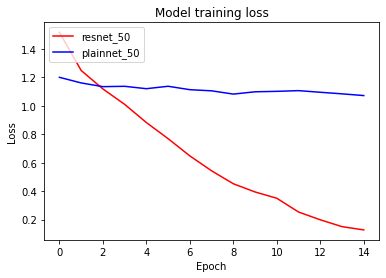

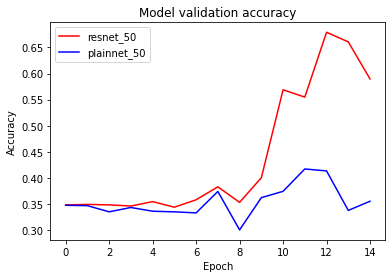

In [25]:

#resnet_50,plainnet_50
BATCH_SIZE = 16
EPOCH = 15

resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_r_50 = resnet_50.fit(
    train_ds,
    steps_per_epoch=train_size/BATCH_SIZE,
    validation_steps=val_size/BATCH_SIZE,
    epochs=EPOCH,
    validation_data=val_ds,
    verbose=1,
    use_multiprocessing=True,
)

plainnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_p_50 = plainnet_50.fit(
    train_ds,
    steps_per_epoch=train_size/BATCH_SIZE,
    validation_steps=val_size/BATCH_SIZE,
    epochs=EPOCH,
    validation_data=val_ds,
    verbose=1,
    use_multiprocessing=True,
)

plt.plot(history_r_50.history['loss'], 'r')
plt.plot(history_p_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plainnet_50'], loc='upper left')
plt.show()

plt.plot(history_r_50.history['val_accuracy'], 'r')
plt.plot(history_p_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plainnet_50'], loc='upper left')
plt.show()